In [1]:
import os
import glob
import sys
import requests
import copy
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

sys.path.append(os.path.join(os.pardir,"src"))
import build_dataset as ds
import cg_optimisers as cg_opt
import plotter

/Users/dorukefegokmen/Documents/Research/RSMI-NE/coarsegrainer/examples/../src/build_dataset.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# RSMI optimisation for the dimer model

## Download sample dataset

In [2]:
url = 'https://polybox.ethz.ch/index.php/s/bUp9a5qZWuLGXMb/download'
filename = 'configs_intdimer2d_square_L64_T15.000.npy'
data_dir = os.path.join(os.pardir, 'data')

if os.path.isfile(os.path.join(data_dir, filename)):
    print('Existing dataset found.')
else:
    print('No existing dataset found.')
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)
        print('Created the data directory.')
    print('Downloading data...')
    r = requests.get(url, allow_redirects=True)
    open(os.path.join(data_dir, filename), 'wb').write(r.content)
    print('Data downloaded into /coarsegrainer/data/.')

Existing dataset found.


## Enter system parameters

In [3]:
data_params = {
    'model': 'intdimer2d',
    'lattice_type': 'square',
    'L': 64,
    'T': 15.000,
    'N_samples': 28800, 
    'dimension': 2,
}

generator=ds.dataset(**data_params)

print(data_params)

Existing data found.
 Loading the data...
Loading complete.
{'model': 'intdimer2d', 'lattice_type': 'square', 'L': 64, 'T': 15.0, 'N_samples': 28800, 'dimension': 2}


## Enter optimisation parameters

In [4]:
CG_params = {'init_temperature': 0.75,
    'min_temperature': 0.1,
    'relaxation_rate': 0.0001, # was 0.0005 for above BKT 0.002 for below BKT
    'Nq': None,
    'conv_activation': None,
    'num_hiddens': 2,
    'h_embed': True,
    'use_probs': False,
    'use_logits': True
}
ll = CG_params['ll'] = (8,8)

critic_params = {
    'layers': 2, 
    'embed_dim': 8, 
    'hidden_dim': 32, 
    'activation': 'relu',
}

opt_params = {
    "batch_size": 500, # was 800 for larger buffers
    "iterations": 250, # was 400 for above BKT, 25 for below BKT
    "shuffle": 100000,
    "learning_rate": 9e-3 # was 4e-3
}

index = (10, 10) # index of the visible patch to be coarse-grained
buffer_size = 4
env_size = 4

V, E = generator.rsmi_data(index, ll, buffer_size=buffer_size, cap=ll[0]+2*(buffer_size+env_size))

Preparing the RSMI dataset...
RSMI dataset prepared.


## Perform the optimisation and plot results

In [5]:
estimates, _, filters, _ = cg_opt.train_RSMI_optimiser(CG_params, critic_params, opt_params, data_params, 
                                                       E=E, V=V)

  0%|          | 0/14400 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Training complete.


RSMI estimate is  0.2990450126009397


/Users/dorukefegokmen/Documents/Research/RSMI-NE/coarsegrainer/src/plotter.py:182: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [


{'init_temperature': 0.75, 'min_temperature': 0.1, 'relaxation_rate': 0.0001, 'Nq': None, 'conv_activation': None, 'num_hiddens': 2, 'h_embed': True, 'use_probs': False, 'use_logits': True, 'll': (8, 8)}
{'layers': 2, 'embed_dim': 8, 'hidden_dim': 32, 'activation': 'relu'}
{'batch_size': 500, 'iterations': 250, 'shuffle': 100000, 'learning_rate': 0.009}


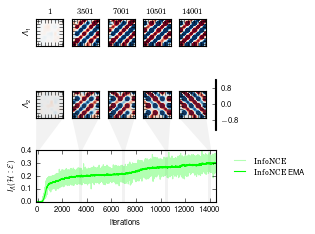

In [6]:
print('RSMI estimate is ', cg_opt.RSMI_estimate(estimates, ema_span=100))

plotter.plot_fancy_rsmimax(estimates, filters, opt_params, CG_params, 
                            generator, N_samples=data_params['N_samples'],
                            mi_bound='InfoNCE', filter_lim=1.3, EMA_span=80, save=False, 
                            series_skip=data_params['N_samples']//(opt_params['batch_size']*4)*opt_params['iterations'], 
                            interpolation='hanning', cmap='RdBu')

print(CG_params)
print(critic_params)
print(opt_params)